In [1]:
%matplotlib inline
%load_ext ipycache

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 300
import numpy as np
import scipy
import sklearn as sk
import xgboost as xgb

from eli5 import show_weights

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

/Users/evgeny/Library/Python/2.7/lib/python/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [
        (math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 
        for i,pred in enumerate(y_pred)
    ]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def rmse(y, y_pred):
    return np.sqrt(((y_pred - y) ** 2).mean())

# Препроцессинг фич

In [19]:
# train_raw = pd.read_csv("data/train.csv")
train_raw = pd.read_csv("data/train_without_noise.csv")
macro = pd.read_csv("data/macro.csv")
train_raw.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [20]:
def preprocess_anomaly(df):
    df["full_sq"] = map(lambda x: x if x > 10 else float("NaN"), df["full_sq"])
    df["life_sq"] = map(lambda x: x if x > 5 else float("NaN"), df["life_sq"])
    df["kitch_sq"] = map(lambda x: x if x > 2 else float("NaN"), df["kitch_sq"])
    
    # superclean
    # https://www.kaggle.com/keremt/very-extensive-cleaning-by-sberbank-discussions
    df.ix[df[df.life_sq > df.full_sq].index, "life_sq"] = np.NaN
    df.ix[df[df.kitch_sq >= df.life_sq].index, "kitch_sq"] = np.NaN

    df.ix[df[df.kitch_sq == 0].index, "kitch_sq"] = np.NaN
    df.ix[df[df.kitch_sq == 1].index, "kitch_sq"] = np.NaN

    df.ix[df[df.build_year < 1500].index, "build_year"] = np.NaN
    df.ix[df[df.build_year > 2017].index, "build_year"] = np.NaN

    df.ix[df[df.num_room == 0].index, "num_room"] = np.NaN
    
    df.ix[df[df.floor == 0].index, "floor"] = np.NaN
    df.ix[df[df.max_floor == 0].index, "max_floor"] = np.NaN
    
    df.ix[df[df.floor > df.max_floor].index, "max_floor"] = np.NaN
    
    df.ix[df[df.state == 33].index, "state"] = np.NaN
    return df

In [21]:
def preprocess_categorial(df):
    df = mess_y_categorial(df, 5)
    df = df.select_dtypes(exclude=['object'])
    return df

def apply_categorial(test, train):
    test = mess_y_categorial_fold(test, train)
    test = test.select_dtypes(exclude=['object'])
    return test


def smoothed_likelihood(targ_mean, nrows, globalmean, alpha=10):
    try:
        return (targ_mean * nrows + globalmean * alpha) / (nrows + alpha)
    except Exception:
        return float("NaN")


def mess_y_categorial(df, nfolds=3, alpha=10):
    from sklearn.utils import shuffle
    from copy import copy

    folds = np.array_split(shuffle(df), nfolds)
    newfolds = []
    for i in range(nfolds):
        fold = folds[i]

        other_folds = copy(folds)
        other_folds.pop(i)
        other_fold = pd.concat(other_folds)

        newfolds.append(mess_y_categorial_fold(fold, other_fold, alpha=10))

    return pd.concat(newfolds)

def mess_y_categorial_fold(fold_raw, other_fold, cols=None, y_col="price_doc", alpha=10):
    fold = fold_raw.copy()
    if not cols:
        cols = list(fold.select_dtypes(include=["object"]).columns)
    globalmean = other_fold[y_col].mean()
    for c in cols:

        target_mean = other_fold[[c, y_col]].groupby(c).mean().to_dict()[y_col]
        nrows = other_fold[c].value_counts().to_dict()

        fold[c + "_sll"] = fold[c].apply(
            lambda x: smoothed_likelihood(target_mean.get(x), nrows.get(x), globalmean, alpha) if x else float("NaN")
        )
    return fold

def feature_exclude(df):
    feats = list(pd.read_csv("/tmp/sber_feat_exclude.tsv", sep="\t", names=["feature"])["feature"].values)
    df = df.drop(feats, axis=1)
    return df

In [22]:
def apply_macro(df):
    macro_cols = [
        'timestamp', "balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
        "micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
        "income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"
    ]
    return pd.merge(df, macro, on='timestamp', how='left')

In [23]:
def preprocess(df):
    from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
    
#     df = apply_macro(df)

    ecology = ["no data", "poor", "satisfactory", "good", "excellent"]
    df["ecology_index"] = map(ecology.index, df["ecology"].values)
    
    bool_feats = [
        "thermal_power_plant_raion",
        "incineration_raion",
        "oil_chemistry_raion",
        "radiation_raion",
        "railroad_terminal_raion",
        "big_market_raion",
        "nuclear_reactor_raion",
        "detention_facility_raion",
        "water_1line",
        "big_road1_1line",
        "railroad_1line",
        "culture_objects_top_25"
    ]
    for bf in bool_feats:
        df[bf + "_bool"] = map(lambda x: x == "yes", df[bf].values)

    df = preprocess_anomaly(df)

    df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
    df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)
    df['rel_life_sq'] = df['life_sq'] / df['full_sq'].astype(float)

    df["material_cat"] = df.material.fillna(0).astype(int).astype(str).replace("0", "")
    df["state_cat"] = df.state.fillna(0).astype(int).astype(str).replace("0", "")
    df["num_room_cat"] = df.num_room.fillna(0).astype(int).astype(str).replace("0", "")
    df["build_year_cat"] = df.build_year.fillna(0).astype(int).astype(str).replace("0", "")    

#     df["age_of_building"] = df["timestamp"].astype(int) - df["build_year"].astype(int)

    # TODO: check metro
    df["ID_metro"] = df.ID_metro.fillna(-10).astype(int).astype(str).replace("-10", "")
#     df["ID_railroad_station_walk"] = df.ID_railroad_station_walk.fillna(-10).astype(int).astype(str).replace("-10", "")
#     df["ID_big_road1"] = df.ID_big_road1.fillna(-10).astype(int).astype(str).replace("-10", "")
#     df["ID_big_road2"] = df.ID_big_road2.fillna(-10).astype(int).astype(str).replace("-10", "")
#     df["ID_bus_terminal"] = df.ID_bus_terminal.fillna(-10).astype(int).astype(str).replace("-10", "")

#     # ratio of living area to full area #
#     df["ratio_life_sq_full_sq"] = df["life_sq"] / np.maximum(df["full_sq"].astype("float"),1)
#     df["ratio_life_sq_full_sq"].ix[df["ratio_life_sq_full_sq"]<0] = 0
#     df["ratio_life_sq_full_sq"].ix[df["ratio_life_sq_full_sq"]>1] = 1

#     # ratio of kitchen area to living area #
#     df["ratio_kitch_sq_life_sq"] = df["kitch_sq"] / np.maximum(df["life_sq"].astype("float"),1)
#     df["ratio_kitch_sq_life_sq"].ix[df["ratio_kitch_sq_life_sq"]<0] = 0
#     df["ratio_kitch_sq_life_sq"].ix[df["ratio_kitch_sq_life_sq"]>1] = 1

#     # ratio of kitchen area to full area #
#     df["ratio_kitch_sq_full_sq"] = df["kitch_sq"] / np.maximum(df["full_sq"].astype("float"),1)
#     df["ratio_kitch_sq_full_sq"].ix[df["ratio_kitch_sq_full_sq"]<0] = 0
#     df["ratio_kitch_sq_full_sq"].ix[df["ratio_kitch_sq_full_sq"]>1] = 1

    df = df.drop(["id", "timestamp"], axis=1)

    return df

In [24]:
train_pr = preprocess(train_raw)
train_pr = preprocess_categorial(train_pr)
train = feature_exclude(train_pr)
# train = train.fillna(-1)

X = train.drop(["price_doc"], axis=1)
y = train["price_doc"].values

/Users/evgeny/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/evgeny/Library/Python/2.7/lib/python/site-package

# Обучение моделей

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.20, random_state=43)

dtrain_all = xgb.DMatrix(X.values, y, feature_names=X.columns)
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X.columns)
dval = xgb.DMatrix(X_val, y_val, feature_names=X.columns)

In [26]:
xgb_params = {
    'max_depth': 5,
    'n_estimators': 200,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
model = xgb.train(xgb_params, dtrain, num_boost_round=4000, evals=[(dval, 'val')],
                  early_stopping_rounds=40, verbose_eval=40)

num_boost_round = model.best_iteration

[0]	val-rmse:8.18176e+06
Will train until val-rmse hasn't improved in 40 rounds.
[40]	val-rmse:5.84542e+06
[80]	val-rmse:4.40358e+06
[120]	val-rmse:3.5612e+06
[160]	val-rmse:3.11097e+06
[200]	val-rmse:2.8731e+06
[240]	val-rmse:2.7628e+06
[280]	val-rmse:2.70953e+06
[320]	val-rmse:2.68658e+06
[360]	val-rmse:2.67422e+06
[400]	val-rmse:2.66337e+06
[440]	val-rmse:2.65572e+06
[480]	val-rmse:2.65078e+06
[520]	val-rmse:2.64819e+06
[560]	val-rmse:2.64463e+06
[600]	val-rmse:2.63955e+06
[640]	val-rmse:2.6366e+06
[680]	val-rmse:2.63367e+06
[720]	val-rmse:2.63168e+06
[760]	val-rmse:2.62902e+06
[800]	val-rmse:2.62759e+06
[840]	val-rmse:2.62644e+06
[880]	val-rmse:2.625e+06
[920]	val-rmse:2.62385e+06
[960]	val-rmse:2.62297e+06
[1000]	val-rmse:2.6222e+06
[1040]	val-rmse:2.62168e+06
[1080]	val-rmse:2.62068e+06
[1120]	val-rmse:2.61989e+06
[1160]	val-rmse:2.61878e+06
[1200]	val-rmse:2.61826e+06
[1240]	val-rmse:2.61753e+06
[1280]	val-rmse:2.61647e+06
[1320]	val-rmse:2.61532e+06
[1360]	val-rmse:2.61374e+06


[0]	train-rmse:8.41582e+06+58219.2	test-rmse:8.41631e+06+116481
[40]	train-rmse:6.01307e+06+43397.7	test-rmse:6.0704e+06+105032
[80]	train-rmse:4.48842e+06+31003.3	test-rmse:4.61736e+06+97260.5
[120]	train-rmse:3.54961e+06+22749.3	test-rmse:3.76382e+06+88414.2
[160]	train-rmse:2.98797e+06+20357.6	test-rmse:3.2924e+06+84215
[200]	train-rmse:2.66142e+06+17889.7	test-rmse:3.04154e+06+81310.8
[240]	train-rmse:2.46839e+06+13994.8	test-rmse:2.9093e+06+77759.2
[280]	train-rmse:2.35039e+06+11269.6	test-rmse:2.83927e+06+75130.7
[320]	train-rmse:2.27711e+06+9482.3	test-rmse:2.80049e+06+72461.9
[360]	train-rmse:2.22627e+06+5199.05	test-rmse:2.77924e+06+70975
[400]	train-rmse:2.19046e+06+4219.26	test-rmse:2.7639e+06+70936.6
[440]	train-rmse:2.15983e+06+4138.33	test-rmse:2.75408e+06+72561.4
[480]	train-rmse:2.13423e+06+5365.5	test-rmse:2.74557e+06+72655.1
[520]	train-rmse:2.11078e+06+6038.48	test-rmse:2.73792e+06+73227.9
[560]	train-rmse:2.09249e+06+6564.7	test-rmse:2.73241e+06+72618
[600]	train-rm

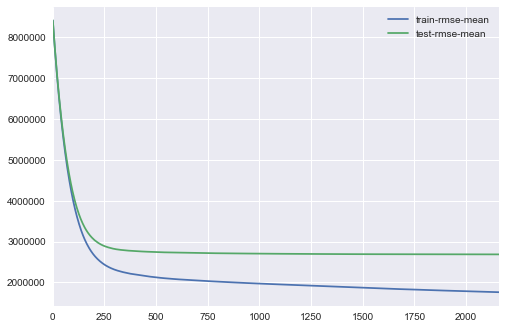

In [27]:
cv_output = xgb.cv(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round, verbose_eval=40)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [28]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round, verbose_eval=40)
print "predict-train:", rmse(model.predict(dtrain_all), y)

predict-train: 1875707.6581


In [ ]:
model = xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.01, nthread=-1, silent=False)
model.fit(X.values, y, verbose=20)

with open("scores.tsv", "a") as sf:
    sf.write("%s\n" % rmsle(model.predict(X.values), y))

!tail scores.tsv

In [ ]:
show_weights(model, feature_names=list(X.columns), importance_type="weight")

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def validate(clf):c
    cval = np.abs(cross_val_score(clf, X.values, y, cv=3, 
                                  scoring=make_scorer(rmsle, False), verbose=2))
    return np.mean(cval), cval

print validate(model)

# Submission

In [29]:
test = pd.read_csv("data/test.csv")

test_pr = preprocess(test)
train_pr = preprocess(train_raw)
test_pr = apply_categorial(test_pr, train_pr)
test_pr = feature_exclude(test_pr)
# test_pr = test_pr.fillna(-1)

dtest = xgb.DMatrix(test_pr.values, feature_names=test_pr.columns)
y_pred = model.predict(dtest)

# y_pred = model.predict(test_pr.values)

# y_pred = np.exp(y_pred) - 1

submdf = pd.DataFrame({"id": test["id"], "price_doc": y_pred})
submdf.to_csv("data/submission.csv", header=True, index=False)
!head data/submission.csv

/Users/evgeny/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:49: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/evgeny/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:53: DeprecationWarning: 

id,price_doc
30474,5432794.5
30475,8294625.5
30476,5690412.5
30477,6195825.0
30478,5198779.0
30479,8662664.0
30480,4462872.0
30481,3962283.25
30482,4572791.5


5*200, no macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.63772e+06
    train-rmse:1.9989e+06+10986.4	test-rmse:2.69158e+06+53020
    predict-train: 2076010.27131
    kaggle: 0.31720

5*200, no macro, add rel features, no log price, train_with_noise:

    val-rmse:2.53378e+06
    train-rmse:1.95069e+06+16166.4	test-rmse:2.69703e+06+61455.1
    predict-train: 2054421.59869
    kaggle: 0.32056

5*200, macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.79632e+06
    train-rmse:1.81015e+06+19781.2	test-rmse:2.6641e+06+123875
    predict-train: 1904063.27368
    kaggle: 0.32976

5*200, no macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.61682e+06
    train-rmse:1.81123e+06+27681.2	test-rmse:2.66923e+06+53925.7
    predict-train: 1899129.43771
    kaggle: 0.31592

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter:

    val-rmse:2.61055e+06
    train-rmse:1.71826e+06+30076.1	test-rmse:2.66515e+06+54583.5
    predict-train: 1814572.97424
    kaggle: 0.31602

7*300, no macro, add rel features, no log price, train_without_noise, 4000 iter:

    val-rmse:2.59955e+06
    train-rmse:1.41393e+06+21208.1	test-rmse:2.6763e+06+35553.3
    predict-train: 1548257.49121
    kaggle: 0.31768

4*300, no macro, add rel features, no log price, train_without_noise, 4000 iter:
    
    val-rmse:2.63407e+06
    train-rmse:1.96513e+06+21470.8	test-rmse:2.69417e+06+74288.3
    predict-train: 2062299.41091
    kaggle: 0.31952

7*200, no macro, add rel features, no log price, train_without_noise, 4000 iter:

    val-rmse:2.59955e+06
    train-rmse:1.41393e+06+21208.1	test-rmse:2.6763e+06+35553.3
    predict-train: 1548257.49121

5*300, no macro, add rel features, no log price, train_without_noise, 4000 iter:
    
    val-rmse:2.61055e+06
    train-rmse:1.71826e+06+30076.1	test-rmse:2.66515e+06+54583.5
    predict-train: 1814572.97424

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna:

    val-rmse:2.61664e+06
    train-rmse:1.77892e+06+23111	test-rmse:2.65829e+06+56398.6
    predict-train: 1875799.54634
    kaggle: 0.31521

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean:
    
    val-rmse:2.6265e+06
    train-rmse:1.78478e+06+22545.4	test-rmse:2.66179e+06+60626.3
    predict-train: 1881672.27588
    kaggle: 0.31476

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, no super features + Label Encoding:
    
    val-rmse:2.56494e+06
    train-rmse:1.78862e+06+18589.1	test-rmse:2.69283e+06+79861.4
    predict-train: 1923466.41923
    kaggle: 0.31434

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, remove material state num_room:
    
    val-rmse:2.56932e+06
    train-rmse:1.88495e+06+20133.7	test-rmse:2.69624e+06+70491.2
    predict-train: 1979198.19201
    kaggle: 0.31513

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, ID metro/bus...:
    
    val-rmse:2.60017e+06
    train-rmse:1.80654e+06+19453.5	test-rmse:2.68203e+06+68169.5
    predict-train: 1906439.98603
    kaggle: 0.31927

5*200, no macro, add rel features, no log price, train_without_noise, 4000 iter, not fillna, superclean, ID metro, remove 50 features:
    
    val-rmse:2.93665e+06
    train-rmse:1.73425e+06+19462.4	test-rmse:2.68682e+06+140661
    predict-train: 1861268.6455
    kaggle: 0.31555

5*200, no macro, add rel features, no log price, train_without_noise, 
4000 iter, not fillna, superclean, ID metro, remove 50 features, add ratio feats:

    val-rmse:2.59747e+06
    train-rmse:1.75828e+06+26639.4	test-rmse:2.68491e+06+67201.8
    predict-train: 1875707.6581
    kaggle: 0.31760

In [30]:
imp_features = pd.DataFrame(
    model.get_fscore().items(), 
    columns=['feature','importance']
).sort_values('importance', ascending=False)
imp_features

,feature,importance
82,full_sq,7657
156,life_sq,1846
196,floor,1719
20,max_floor,1447
101,ID_metro_sll,1219
154,build_year,1179
153,build_year_cat_sll,1090
32,rel_life_sq,1019
197,rel_floor,823
9,sub_area_sll,783


In [ ]:
features[-50:][["feature"]].to_csv("/tmp/sber_feat_exclude.tsv", sep="\t", index=False, header=False)
!head -n 100 /tmp/sber_feat_exclude.tsv